In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from matplotlib import pyplot as plt
from IPython import display 

In [2]:
from code_AVO import SimpleModel, make_optimizer_step, get_gradient_penalty

In [3]:
critic = SimpleModel()

#### First example

In [4]:
batch_size = 50
learning_rate = 0.001
lambda_gradient = 0.001 # Gradient penalty
lambda_entropy = 0. #3. # Entropy penalty
data_poisson_rate = 7.
proposal_initial_mu = np.log(5)
proposal_initial_lg_sigma = 0.
beta1 = 0.5
beta2 = 0.9
critic_steps = 100
count_steps = 5000

batch_shape = (batch_size, 1)
critic_shape = (batch_size, 1)
data_distribution = torch.distributions.Poisson(data_poisson_rate)

# data_op.requires_grad = True

In [5]:
mu = torch.tensor(proposal_initial_mu, requires_grad=True)
lg_sigma = torch.tensor(proposal_initial_lg_sigma, requires_grad=True)
entropy_proposal_op = lg_sigma

In [6]:
critic_optimizer = torch.optim.Adam(critic.parameters(), lr=learning_rate, betas=(beta1, beta2))
proposal_optimizer = torch.optim.Adam([mu, lg_sigma], lr=learning_rate, betas=(beta1, beta2))

In [7]:
critic_losses = np.zeros(count_steps)
proposal_losses = np.zeros(count_steps)
hist_mu = np.zeros(count_steps)
hist_lg_sigma = np.zeros(count_steps)

Step 4900: mu = 1.928253412246704, sigma = 0.1433049589395523, critic_loss = 7087.18212890625


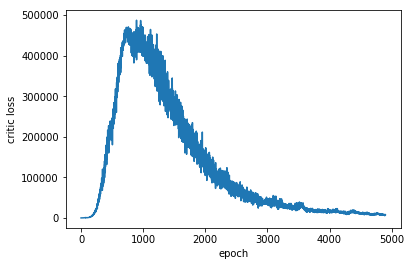

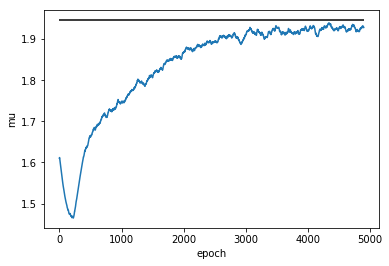

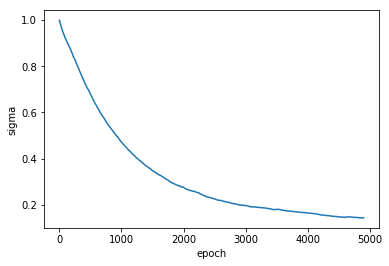

In [8]:
print('Step 0: mu = {}, sigma = {}'.format(mu, torch.exp(lg_sigma)))
_tgp = np.zeros(count_steps)
for epoch in range(0, count_steps):
    _c_l = np.zeros(critic_steps)
    
    for idx in range(0, critic_steps):
        proposal_distribution = torch.distributions.Normal(loc=mu, 
                                                           scale=torch.exp(lg_sigma))
        data_op = data_distribution.sample(torch.Size(batch_shape))
        sample_proposal_op = proposal_distribution.sample(torch.Size(batch_shape))
        lg_proposal_op = proposal_distribution.log_prob(sample_proposal_op)

        simulator_distribution = torch.distributions.Poisson(torch.exp(sample_proposal_op))
        simulate_op = simulator_distribution.sample()

        critic_data = critic(data_op)
        critic_fake = critic(simulate_op)

        gradient_penalty = get_gradient_penalty(data_op, simulate_op, critic)
        critic_loss = torch.mean(critic_fake - critic_data + lambda_gradient * gradient_penalty)

        make_optimizer_step(critic_loss, critic_optimizer)
    
    _tgp[epoch] = gradient_penalty
    critic_loss = torch.mean(critic_fake - critic_data + gradient_penalty)
    critic_losses[epoch] = critic_loss
    
    sample_proposal_op = proposal_distribution.sample(torch.Size(batch_shape))
    lg_proposal_op = proposal_distribution.log_prob(sample_proposal_op)

    simulator_distribution = torch.distributions.Poisson(torch.exp(sample_proposal_op))
    simulate_op = simulator_distribution.sample()

    critic_fake = critic(simulate_op)

    loss_proposal = torch.mean(-critic_fake * lg_proposal_op + lambda_entropy * proposal_distribution.entropy())
    proposal_losses[epoch] = loss_proposal

    make_optimizer_step(loss_proposal, proposal_optimizer, retain_graph=True)
    
    hist_mu[epoch] = mu
    hist_lg_sigma[epoch] = lg_sigma
    if epoch%100 == 0:
        display.clear_output()
        print('Step {}: mu = {}, sigma = {}, critic_loss = {}'.format(epoch, mu, torch.exp(lg_sigma), critic_loss))
        
        plt.plot(critic_losses[:epoch])
        plt.xlabel('epoch')
        plt.ylabel('critic loss')

        plt.figure()
        plt.hlines(np.log(7.), 0, epoch)
        plt.plot(hist_mu[:epoch])
        plt.xlabel('epoch')
        plt.ylabel('mu')

        plt.figure()
        plt.plot(np.exp(hist_lg_sigma[:epoch]))
        plt.xlabel('epoch')
        plt.ylabel('sigma')

        plt.show()

Text(0,0.5,'gradient penalty')

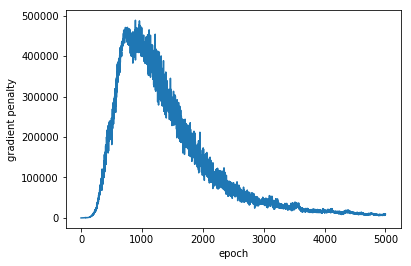

In [9]:
plt.plot(_tgp)
plt.xlabel('epoch')
plt.ylabel('gradient penalty')

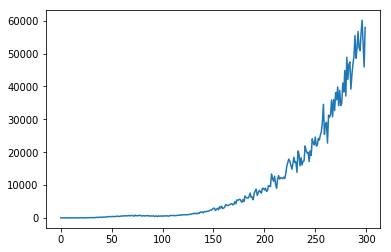

In [10]:
plt.plot(critic_losses[:300])